In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                    MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D,
                                    Conv1D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
import os
import gc
import tensorflow.keras.backend as K
# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
#FORECAST_STEPS = 10
TEST_RATIO = 0  # For validation split during training
TEST_SIZE_POURCENTAGE = 1
# Tuning parameters
EPOCHS_LIST = [20]
BATCH_SIZES = [128]
# Transformer parameters for anomaly detection
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DROPOUT_RATE = 0.1
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
# Load detection dataset
file_path_detection = '../../data/cleaned_labeled_dataset.csv'
#file_path_detection = '../../data/preprocessed_data.csv'
df_detection = pd.read_csv(file_path_detection, delimiter=',')
df_detection['DateTime'] = pd.to_datetime(df_detection['DateTime'], errors='coerce')
df_detection.set_index('DateTime', inplace=True)

# Extract labels column if it exists from detection dataset
if 'labels' in df_detection.columns:
    print("✅ Found 'labels' column in detection dataset. Extracting for later evaluation.")
    labels_detection = df_detection['labels'].copy()
    df_detection_train = df_detection.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in detection dataset. Will assume all samples are normal.")
    labels_detection = pd.Series(np.zeros(len(df_detection)))
    df_detection_train = df_detection.copy()

✅ GPU is available and will be used.
✅ Found 'labels' column in detection dataset. Extracting for later evaluation.


In [71]:
# ========================
# 4. LOAD TEST SET
# ========================
# Load the test set from CSV
test_set_path = 'labeled_test_set_with_predictions.csv'
df_test = pd.read_csv(test_set_path, delimiter=',')
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test.set_index('DateTime', inplace=True)
print(f"✅ Loaded test set with {len(df_test)} samples from {test_set_path}")

# Extract labels from test set if they exist
if 'labels' in df_test.columns:
    print("✅ Found 'labels' column in test set.")
    all_test_labels = df_test['labels'].copy()
    df_test_features = df_test.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in test set. Will assume all samples are normal.")
    all_test_labels = pd.Series(np.zeros(len(df_test)))
    df_test_features = df_test.copy()

✅ Loaded test set with 10000 samples from labeled_test_set_with_predictions.csv
✅ Found 'labels' column in test set.


In [4]:
import joblib
scaler_detection = joblib.load("scaler.pkl")

In [72]:
# ========================
# 5. NORMALIZE DATA
# ========================
# Normalize detection dataset
scaled_data_detection = scaler_detection.transform(df_detection_train.values)
df_detection_scaled = pd.DataFrame(scaled_data_detection, index=df_detection_train.index, 
                                  columns=df_detection_train.columns).astype(np.float32)
print(f"✅ Scaled detection dataset shape: {df_detection_scaled.shape}")


# Normalize test dataset - using the same scaler as detection dataset for consistency
scaled_data_test = scaler_detection.transform(df_test_features.values)
test_data_scaled = pd.DataFrame(scaled_data_test, index=df_test_features.index, 
                             columns=df_test_features.columns).astype(np.float32)
print(f"✅ Scaled test dataset shape: {test_data_scaled.shape}")



✅ Scaled detection dataset shape: (92277, 25)
✅ Scaled test dataset shape: (10000, 25)


In [33]:
# ========================
# 6. SEQUENTIAL TRAIN/TEST SPLIT FOR MODEL EVALUATION
# ========================
# Split for detection model
split_idx_detection = int((1 - TEST_RATIO) * len(df_detection_scaled))
train_data_detection = df_detection_scaled.iloc[:split_idx_detection]


In [8]:
# ========================
# 6. SEQUENTIAL TRAIN/TEST SPLIT FOR MODEL EVALUATION
# ========================
# Split for detection model
#split_idx_detection = int((1 - TEST_RATIO) * len(df_detection_scaled))
#train_data_detection = df_detection_scaled.iloc[:split_idx_detection]

In [9]:
# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps):
    X = []
    i = 0
    while i + input_steps <= len(data):
        X.append(data[i:i+input_steps])
        i += input_steps  # advance by input_steps to avoid overlap
    return np.array(X, dtype=np.float32)

In [73]:


TEST_SIZE_POURCENTAGE = 1
# Split for test set
split_idx_test = int(TEST_SIZE_POURCENTAGE * len(test_data_scaled))
test_data = test_data_scaled.iloc[:split_idx_test]
test_labels = all_test_labels.iloc[:split_idx_test]

print(f"✅ Detection model - Training samples: {len(train_data_detection)}, Testing samples: {len(test_data)}")

✅ Detection model - Training samples: 92277, Testing samples: 10000


In [11]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data_detection.values, INPUT_STEPS)

def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inp = Input(shape=(input_steps, input_dim))
    
    # Stacked encoder: richer context + bottleneck
    x = LSTM(units, return_sequences=True)(inp)
    x = LSTM(units)(x)  # bottleneck (return_sequences=False)

    # Decoder
    x = RepeatVector(input_steps)(x)
    x = LSTM(units, return_sequences=True)(x)
    out = TimeDistributed(Dense(input_dim))(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model


lstm_ae = build_lstm_autoencoder(INPUT_STEPS, X_ae_train.shape[2])

# Train LSTM AE
es = EarlyStopping(patience=5, restore_best_weights=True)
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=1024, callbacks=[es], verbose=1)
lstm_ae.save("best_lstm_autoencoder_lstmseq2seq.h5")
print("\n✅ LSTM Autoencoder trained and saved.")

Epoch 1/20
82/82 [==============================] - 25s 83ms/step - loss: 0.0336 - val_loss: 0.0046
Epoch 2/20
82/82 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 3/20
82/82 [==============================] - 3s 38ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/20
82/82 [==============================] - 3s 36ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/20
82/82 [==============================] - 3s 37ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/20
82/82 [==============================] - 3s 37ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/20
82/82 [==============================] - 3s 40ms/step - loss: 9.8156e-04 - val_loss: 0.0014
Epoch 8/20
82/82 [==============================] - 3s 38ms/step - loss: 9.1037e-04 - val_loss: 0.0012
Epoch 9/20
82/82 [==============================] - 3s 37ms/step - loss: 8.4962e-04 - val_loss: 0.0013
Epoch 10/20
82/82 [==============================] - 3s 38ms/step - loss: 8.1969e-04 - val_loss:

In [12]:
# 1. Get reconstruction errors from training data (assumed normal)
train_reconstructions = lstm_ae.predict(X_ae_train,batch_size=1024, verbose=1)
train_errors = np.mean((X_ae_train - train_reconstructions) ** 2, axis=(1,2))  # MSE per sequence

# 2. Calculate threshold as high percentile of normal errors
THRESHOLD_PERCENTILE = 99  # Start with 99th percentile
threshold = np.percentile(train_errors, THRESHOLD_PERCENTILE)

print(f"Threshold (P{THRESHOLD_PERCENTILE}): {threshold:.4f}")

91/91 [==============================] - 4s 13ms/step
Threshold (P99): 0.0017


In [13]:
K.clear_session()
gc.collect()

2141

In [74]:
# Use the last 3000 points of the test data for simulation
test_data_tail = test_data.tail(10000).reset_index(drop=True)
test_labels_tail = test_labels.tail(10000).reset_index(drop=True)

# ========================
# 9. REAL-TIME SIMULATION WITH MANUAL THRESHOLD CONTROL
# ========================
simulation_y = create_sequences(test_data_tail.values, INPUT_STEPS)
# Create corresponding labels for evaluation

#
forecast_list = []
#reconstruction_list = []
reconstruction_errors = []
#true_windows = []

# Process each non-overlapping sequence individually
for i in range(len(simulation_y)):
    window_y_true = simulation_y[i]  # shape (INPUT_STEPS, features)
    input_seq = np.expand_dims(window_y_true, axis=0)  # shape (1, INPUT_STEPS, features)
    
    # Skip empty or malformed input
    if input_seq.shape[1] == 0:
        continue

    
    # Reconstruct using LSTM autoencoder
    y_reconstructed = lstm_ae.predict(input_seq, batch_size=1024, verbose=1)[0]  # shape (INPUT_STEPS, features)
    
    # Calculate per-timestep reconstruction error
    timestep_errors = np.mean((window_y_true - y_reconstructed) ** 2, axis=1)  # shape (INPUT_STEPS,)
    
    reconstruction_errors.append(timestep_errors)

print("\n✅ Real-time simulation complete.")

1/1 [==============================] - 0s 72ms/step

✅ Real-time simulation complete.


In [89]:
MANUAL_THRESHOLD=None
MANUAL_PERCENTILE=99
# Flatten the reconstruction errors list for threshold calculation
all_reconstruction_errors = np.concatenate(reconstruction_errors)

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(test_labels_tail), len(all_reconstruction_errors))
true_labels_subset = test_labels_tail[:min_length]
errors_subset = all_reconstruction_errors[:min_length]

# Determine threshold to use
if MANUAL_THRESHOLD is not None:
    # Use manually specified threshold
    threshold = MANUAL_THRESHOLD
    print(f"\n✅ Using manually specified threshold: {threshold:.5f}")
else:
    # Use percentile-based threshold
    threshold = np.percentile(all_reconstruction_errors, MANUAL_PERCENTILE)
    print(f"\n✅ Using {MANUAL_PERCENTILE}th percentile threshold: {threshold:.5f}")


all_detected = (np.array(all_reconstruction_errors) > threshold).astype(np.int32)

# Apply threshold to get anomaly flags
#anomaly_flags_list = [errors > threshold for errors in reconstruction_errors]
#all_detected = np.concatenate([flags for flags in anomaly_flags_list])


✅ Using 99th percentile threshold: 0.00419


In [90]:
# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(true_labels_subset), len(all_detected))
true_labels_subset = true_labels_subset[:min_length]
all_detected_subset = all_detected[:min_length]
# Print summary of anomalies
print(f"\nAnomaly detection summary:")
print(f"Number of true anomalies: {np.sum(true_labels_subset)}")
print(f"Numberof detected anomalies: {np.sum(all_detected_subset)}")


Anomaly detection summary:
Number of true anomalies: 100
Numberof detected anomalies: 100


In [91]:
df_test_copy = df_test.copy()
#df_test_copy = df_test_copy.iloc[:split_idx_test]
original_test_labeled = df_test_copy.tail(10000)

In [92]:
# Step 4: Replace 'labels' column with predicted labels
original_test_labeled.loc[:, 'model-labels'] = all_detected_subset

C:\Users\mohm2\AppData\Local\Temp\ipykernel_14244\3472692232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_test_labeled.loc[:, 'model-labels'] = all_detected_subset


In [93]:
original_test_labeled

,505D002D01.TI0012.MEAS,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530K001S01.FI0007.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0029.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,...,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS,labels,model-labels
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-09-12 09:03:00,92.039062,3.732162,123.099609,87903.882812,2646.858398,1199.784790,-40.518436,2512.876709,310.994293,130.238907,...,144.859375,685.145508,161.373627,19.597656,14.369141,62.644531,12.734332,57.416016,0,1
2024-09-12 09:06:00,92.593750,3.732162,123.216797,88314.742188,2649.918457,1198.051147,-40.252991,2513.240479,311.097595,130.088928,...,145.000000,684.477539,161.504898,20.175781,14.369141,62.158203,12.833099,57.416016,0,0
2024-09-12 09:09:00,92.070312,3.732162,123.322266,88347.742188,2647.785889,1198.416992,-40.347046,2515.395752,311.180054,130.160049,...,145.109375,684.703125,161.373627,20.056641,14.369141,62.541016,12.719937,57.416016,0,0
2024-09-12 09:12:00,92.191406,3.732162,123.082031,88152.593750,2647.335938,1202.797241,-40.069344,2513.609863,310.979492,130.027222,...,145.296875,684.934570,161.373627,20.443359,14.369141,62.509766,12.819610,57.314453,0,0
2024-09-12 09:15:00,92.390625,3.732162,122.759766,87710.257812,2648.240723,1197.469971,-40.265190,2512.722412,311.075134,130.270828,...,145.562500,685.602539,162.029922,19.384766,14.369141,62.128906,12.710178,57.416016,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03 04:48:00,93.937500,4.872401,125.724609,85000.054688,2652.126465,1200.478027,-40.213490,2545.955322,310.741852,126.948265,...,148.546875,684.278320,166.886444,18.605469,16.759766,53.171875,12.762068,57.048828,0,0
2024-10-03 04:51:00,93.613281,4.872401,125.830078,85386.328125,2648.171143,1198.533569,-40.415592,2559.961182,311.295258,119.705246,...,148.531250,688.954102,166.492676,18.136719,17.779297,53.919922,12.768898,57.048828,0,0
2024-10-03 04:54:00,93.714844,4.872401,125.941406,81546.476562,2652.731934,1200.611816,-40.327812,2474.606934,311.846680,118.301117,...,148.250000,689.510742,165.442627,16.675781,17.779297,54.181641,12.768898,56.837891,0,1


In [94]:
# Define the attribute of interest
attribute  = "530R002D02.TI0037.MEAS"
attribute2 = "530M105D01.TIC0022.MEAS"
# Calculate the 10th and 90th percentile thresholds
lower_bound = 674.7158203125
upper_bound = 740.859375

In [95]:
# Only set labels to 1 if the threshold conditions are met — keep existing 1s untouched
original_test_labeled.loc[
    (original_test_labeled[attribute2] < lower_bound) |
    (original_test_labeled[attribute] > upper_bound),
    'model-labels'
] = 1


In [98]:
original_test_labeled

,505D002D01.TI0012.MEAS,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530K001S01.FI0007.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0029.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,...,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS,labels,model-labels
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-09-12 09:03:00,92.039062,3.732162,123.099609,87903.882812,2646.858398,1199.784790,-40.518436,2512.876709,310.994293,130.238907,...,144.859375,685.145508,161.373627,19.597656,14.369141,62.644531,12.734332,57.416016,0,1
2024-09-12 09:06:00,92.593750,3.732162,123.216797,88314.742188,2649.918457,1198.051147,-40.252991,2513.240479,311.097595,130.088928,...,145.000000,684.477539,161.504898,20.175781,14.369141,62.158203,12.833099,57.416016,0,0
2024-09-12 09:09:00,92.070312,3.732162,123.322266,88347.742188,2647.785889,1198.416992,-40.347046,2515.395752,311.180054,130.160049,...,145.109375,684.703125,161.373627,20.056641,14.369141,62.541016,12.719937,57.416016,0,0
2024-09-12 09:12:00,92.191406,3.732162,123.082031,88152.593750,2647.335938,1202.797241,-40.069344,2513.609863,310.979492,130.027222,...,145.296875,684.934570,161.373627,20.443359,14.369141,62.509766,12.819610,57.314453,0,0
2024-09-12 09:15:00,92.390625,3.732162,122.759766,87710.257812,2648.240723,1197.469971,-40.265190,2512.722412,311.075134,130.270828,...,145.562500,685.602539,162.029922,19.384766,14.369141,62.128906,12.710178,57.416016,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03 04:48:00,93.937500,4.872401,125.724609,85000.054688,2652.126465,1200.478027,-40.213490,2545.955322,310.741852,126.948265,...,148.546875,684.278320,166.886444,18.605469,16.759766,53.171875,12.762068,57.048828,0,0
2024-10-03 04:51:00,93.613281,4.872401,125.830078,85386.328125,2648.171143,1198.533569,-40.415592,2559.961182,311.295258,119.705246,...,148.531250,688.954102,166.492676,18.136719,17.779297,53.919922,12.768898,57.048828,0,0
2024-10-03 04:54:00,93.714844,4.872401,125.941406,81546.476562,2652.731934,1200.611816,-40.327812,2474.606934,311.846680,118.301117,...,148.250000,689.510742,165.442627,16.675781,17.779297,54.181641,12.768898,56.837891,0,1


In [96]:



# Compute metrics
precision = precision_score(true_labels_subset, original_test_labeled['model-labels'], zero_division=0)
recall = recall_score(true_labels_subset, original_test_labeled['model-labels'], zero_division=0)
f1 = f1_score(true_labels_subset, original_test_labeled['model-labels'], zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")


📈 Anomaly Detection Evaluation:
Precision: 0.62000
Recall:    0.62000
F1 Score:  0.62000


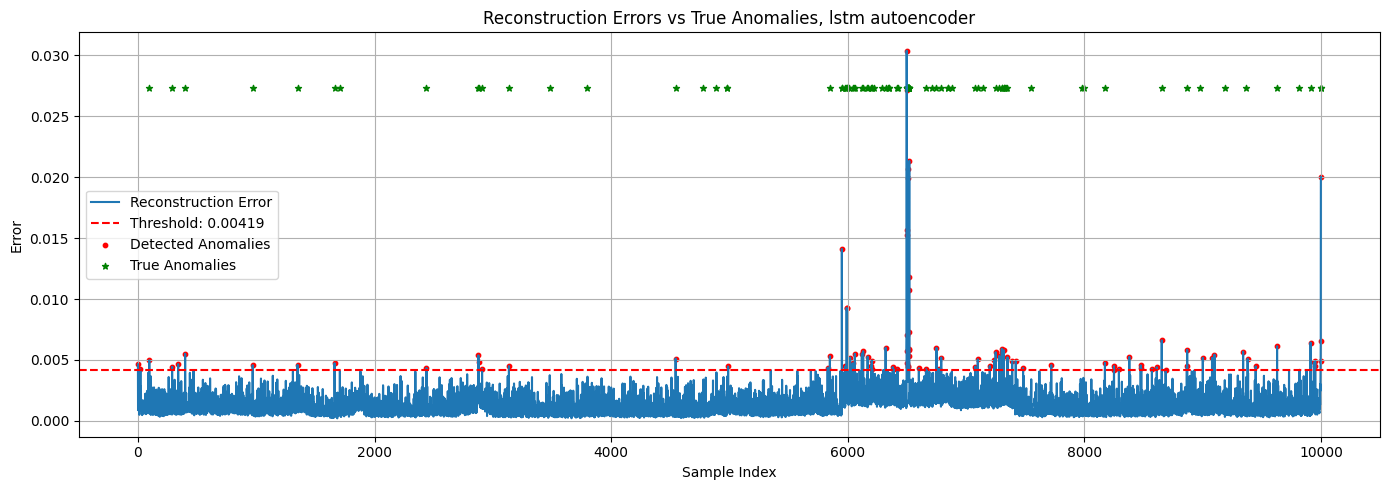


✅ Analysis complete.

To change the threshold:
1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold
2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: 99th)
3. Re-run the script to see results with the new threshold


In [97]:


# ========================
# 10. PLOT RESULTS
# ========================
# Plot Reconstruction Errors with True Labels
plt.figure(figsize=(14,5))

# Ensure we're only plotting up to the minimum length we have data for
min_plot_len = min(len(all_reconstruction_errors), len(true_labels_subset))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = true_labels_subset[:min_plot_len]
plot_detected = all_detected_subset[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies, lstm autoencoder")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_with_threshold.png")
plt.show()

print("\n✅ Analysis complete.")
print("\nTo change the threshold:")
print("1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold")
print("2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: {}th)".format(MANUAL_PERCENTILE))
print("3. Re-run the script to see results with the new threshold")